In [10]:
import sys
from pathlib import Path
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs, low_shelf, high_shelf

In [51]:
def bandwidth(q):
    return np.log2(1 + 1 / (2 * self.q**2) + np.sqrt(((2 * q**2 + 1) / q**2)**2 / 4 - 1))

In [76]:
def biggest_peaks(fr):
    peak_ixs, peak_props = find_peaks(np.clip(fr, 0, None), width=0, prominence=0, height=0)
    dip_ixs, dip_props = find_peaks(np.clip(-fr, 0, None), width=0, prominence=0, height=0)
    
    ixs = np.concatenate([peak_ixs, dip_ixs])
    widths = np.concatenate([peak_props['widths'], dip_props['widths']])
    heights = np.concatenate([peak_props['peak_heights'], dip_props['peak_heights']])
    sizes = widths * heights

    ix_sort = np.argsort(sizes)[::-1]
    ixs = ixs[ix_sort]
    widths = widths[ix_sort]
    heights = heights[ix_sort]
    
    return ixs, widths, heights

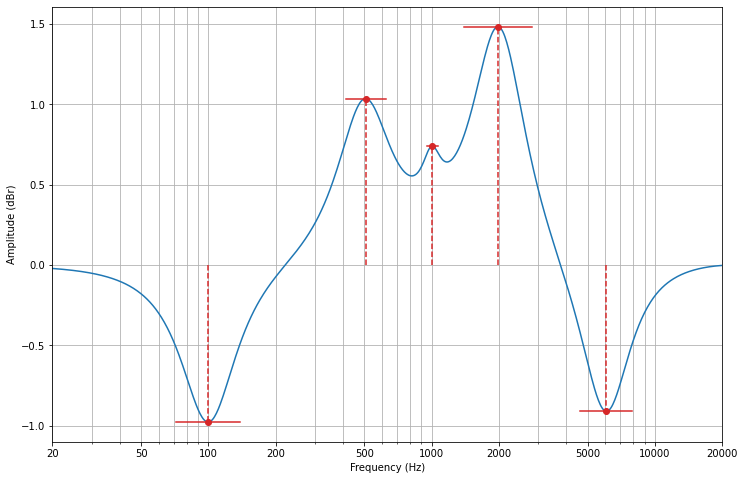

In [79]:
f = FrequencyResponse.generate_frequencies()
f_step = f_step = np.log(f[1] / f[0]) / np.log(2)
fr = digital_coeffs(f, 44100, *peaking([100, 500, 1000, 2000, 6000], [1.4, 1.4, 4, 1.4, 1.4], [-1, 1, 0.3, 1.5, -1], fs=44100), reduce=True)

ixs, widths, heights = biggest_peaks(fr)

fig, ax = FrequencyResponse.init_plot()
ax.plot(f, fr)
ax.plot(f[ixs], fr[ixs], 'o', color='C3')
for ix, width, height in zip(ixs, widths, heights):
    ax.plot(
        [f[max(ix - int(np.round(width / 2)), 0)], f[min(ix + int(np.round(width / 2)), len(f) - 1)]],
        [fr[ix], fr[ix]],
        color='C3'
    )
    height = height if fr[ix] > 0 else -height
    ax.plot([f[ix], f[ix]], [fr[ix] - height, fr[ix]], '--', color='C3')
plt.show()

1983.831049501725 70.84037856478159 1.016934388903993 1.3897206262223782 1.4836277954693866
502.5220250814061 69.88657732528202 1.0032422926690845 1.409461266197018 0.982236547734189
100.25188527717629 68.79495013444637 0.9875716645229025 1.4327138552964735 -0.9990296680473367
5986.557705722541 61.29895082129917 0.8799643982267586 1.6143512338463324 -0.9979844684885375
998.4582096487451 24.356055761039443 0.34963831621557606 4.11616914563652 0.2929740792480837
7831.667939986448 45.49354553188891 0.6530731746759416 2.1903369887200115 -0.07535027335764433
4397.588475772929 44.43212085872153 0.637836112519533 2.2435415668441263 -0.056712394229065044
424.3182848677214 52.20590284373742 0.7494310304543054 1.9035785153605762 0.02343575550111221
73.64274380049768 56.56954847441395 0.8120724419307785 1.753320907445483 -0.01581683195797956
5986.557705722541 20.30842280700608 0.29153335929678376 4.940234998124827 0.04136735518071655
10144.017355995227 42.18969586281605 0.6056454447242047 2.36467

C:\Users\jaakko\code\AutoEq\frequency_response.py:1737: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


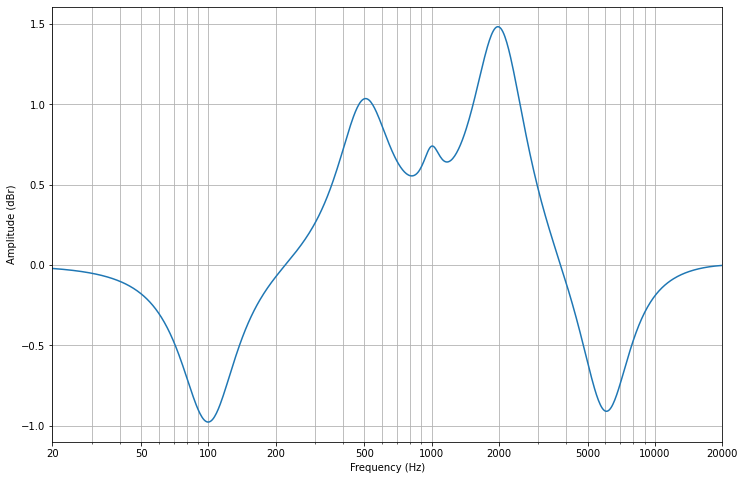

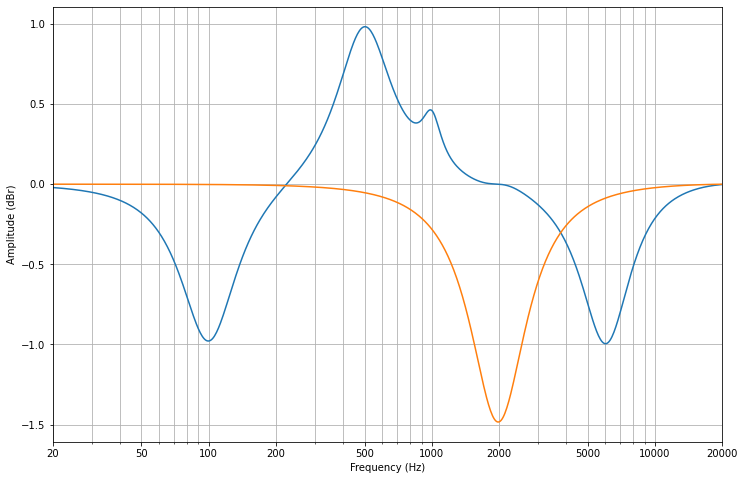

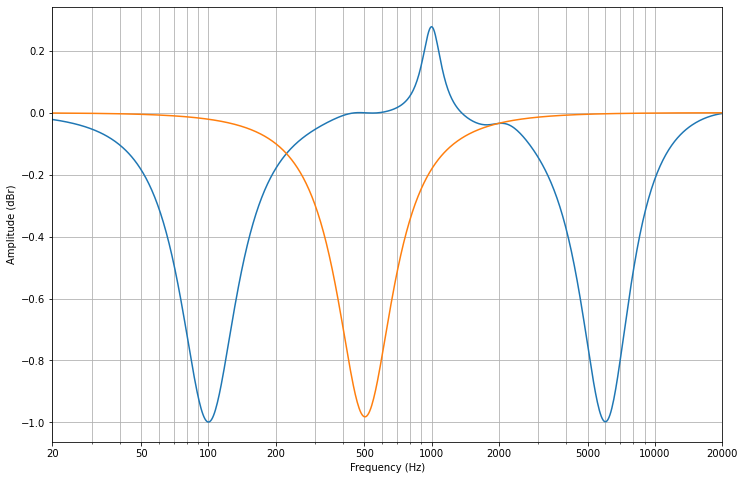

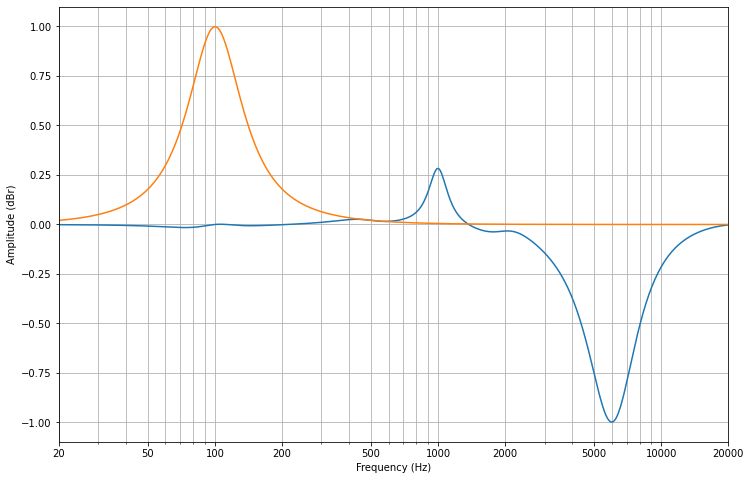

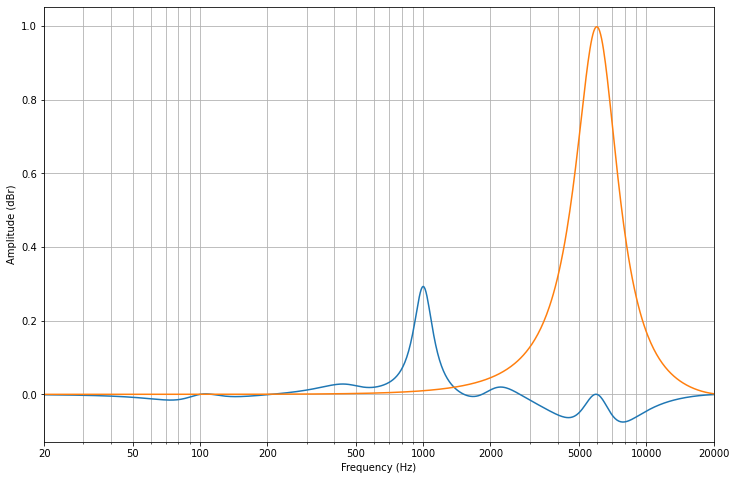

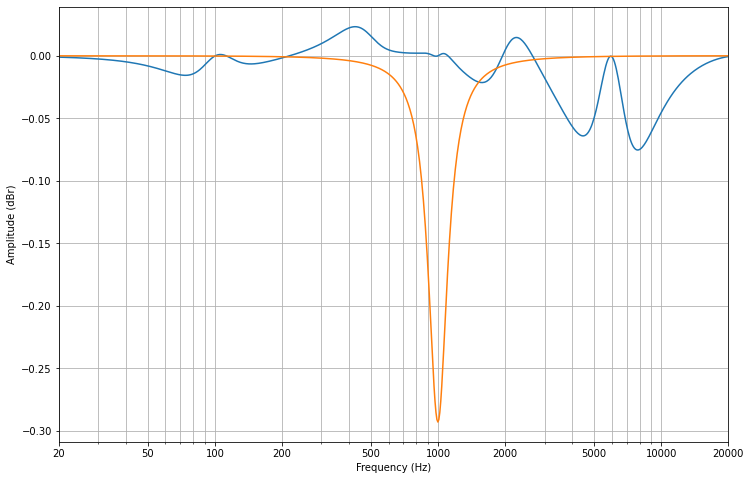

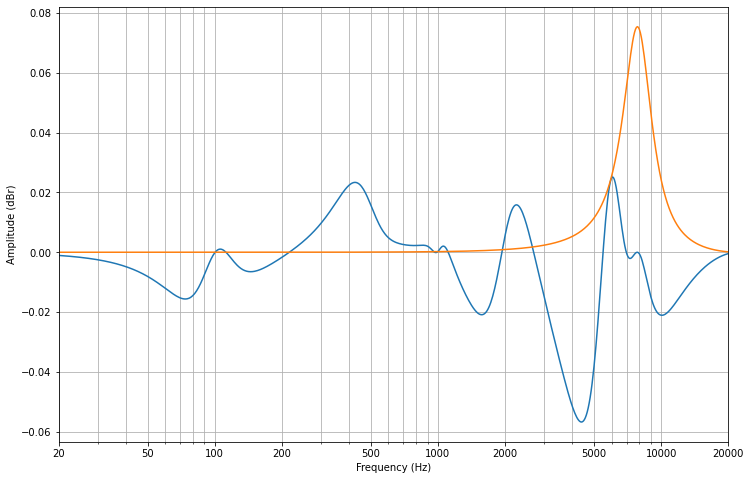

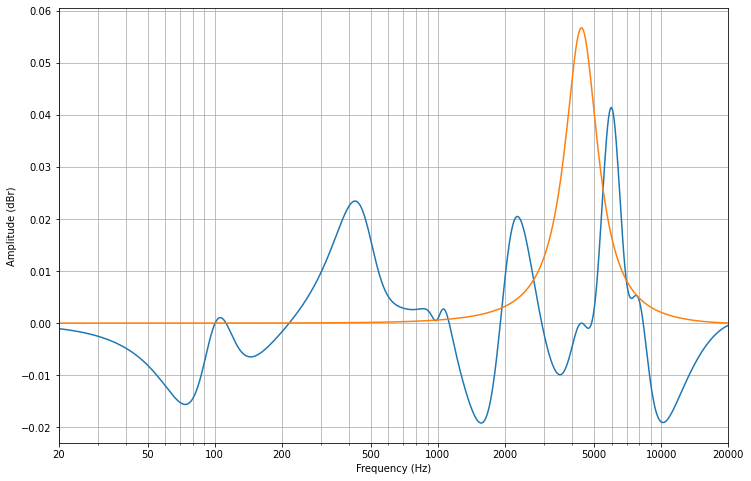

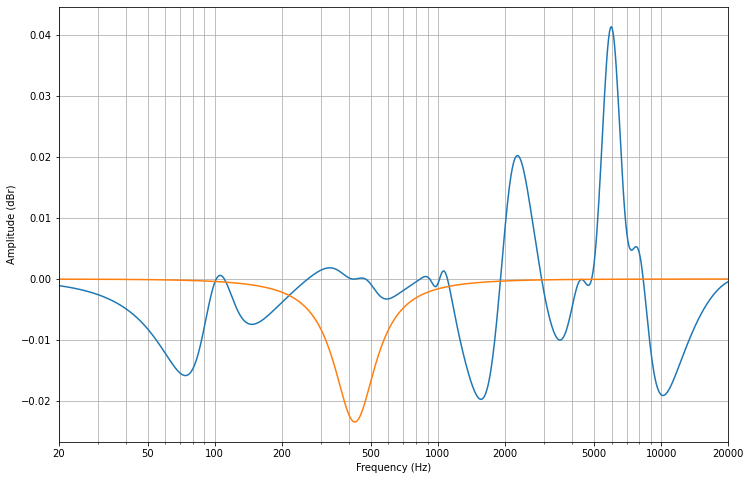

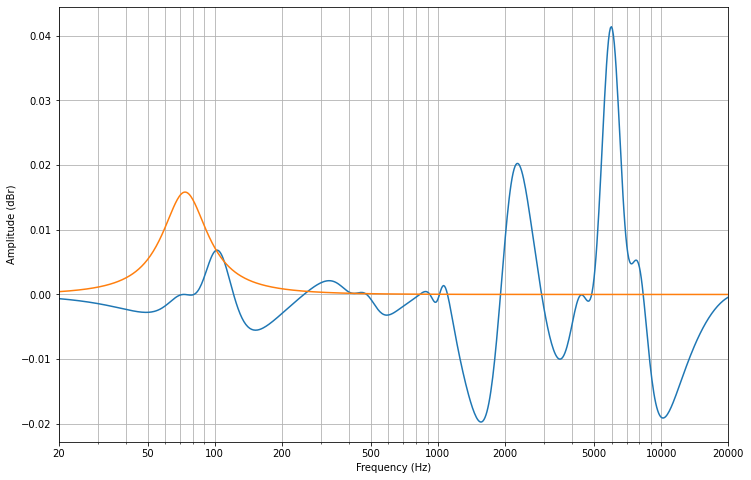

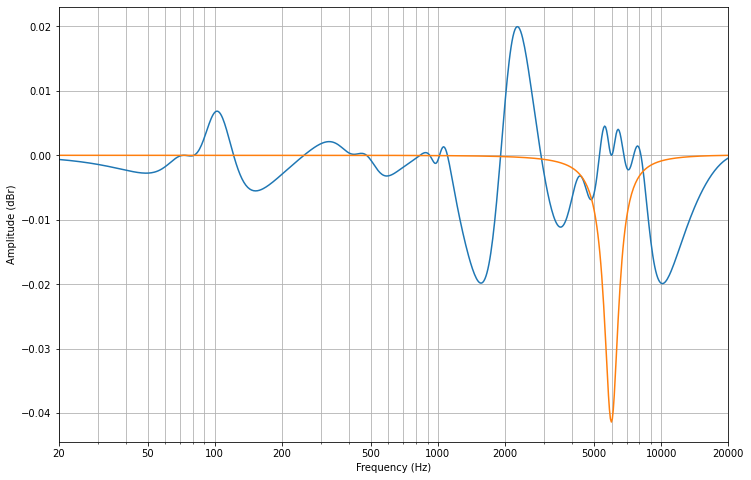

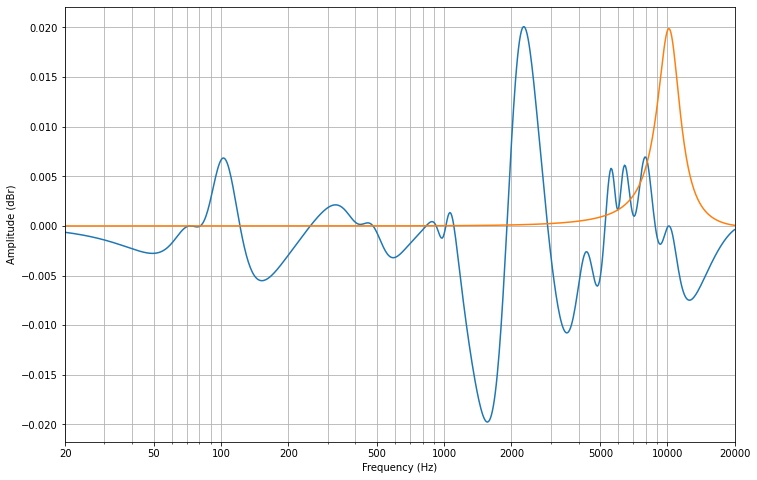

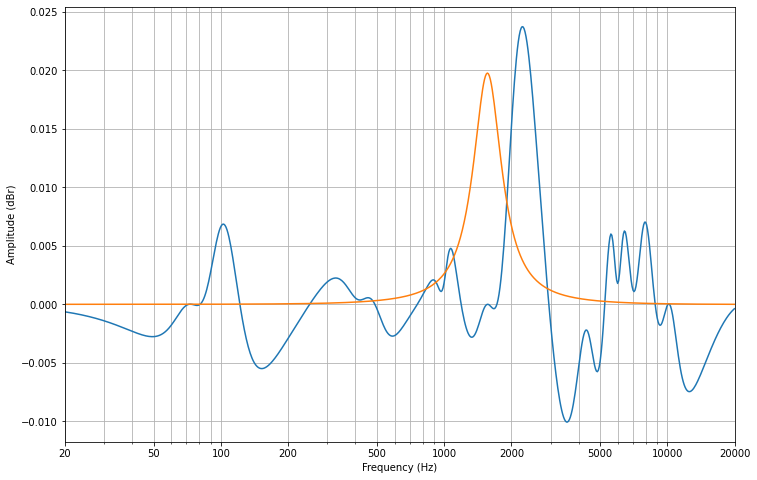

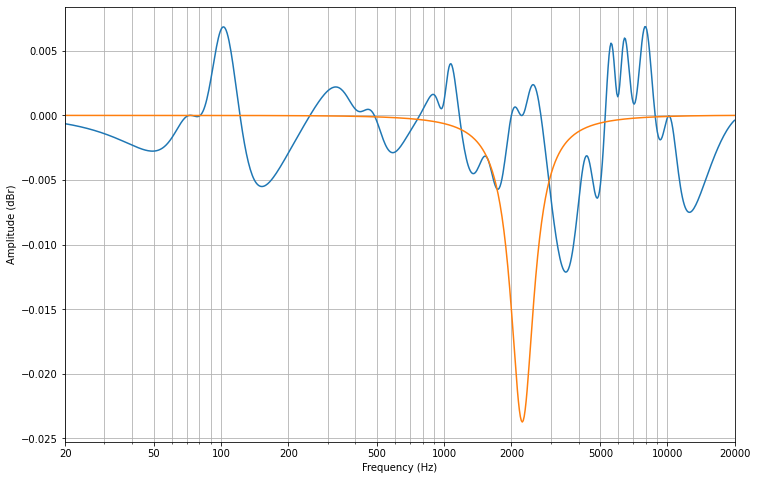

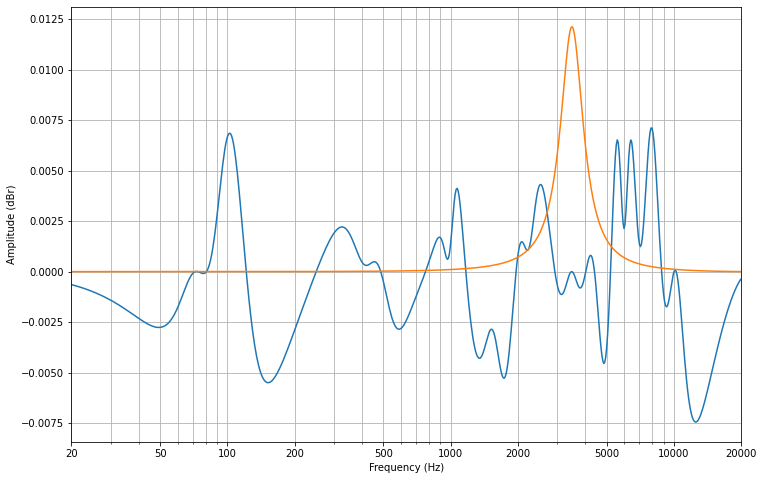

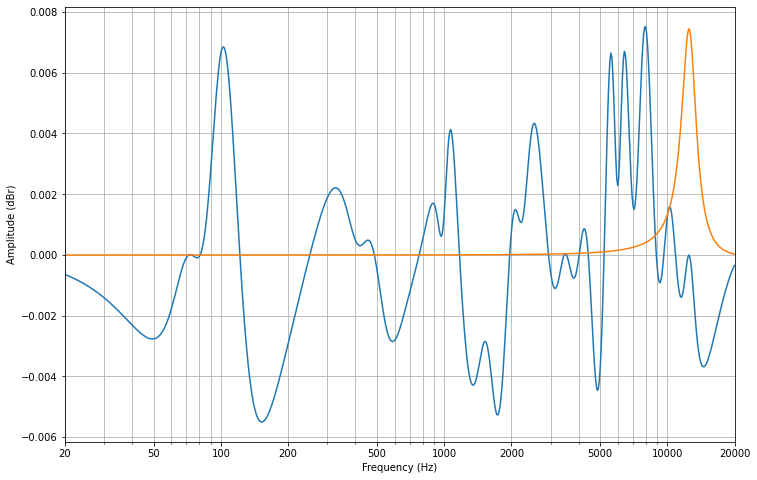

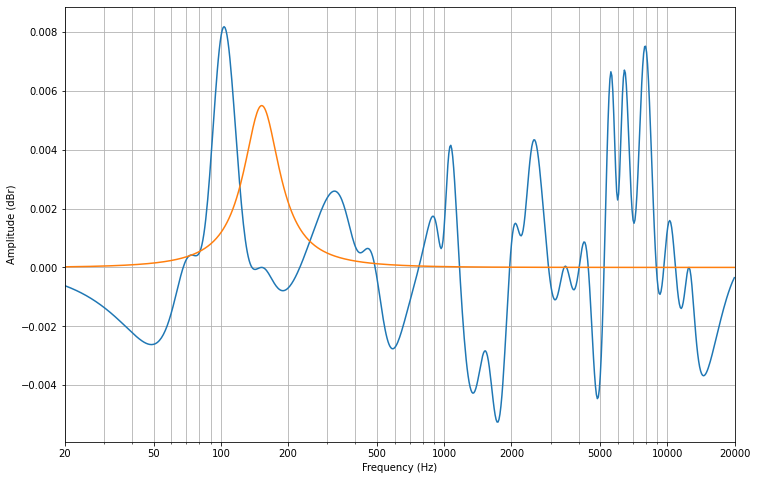

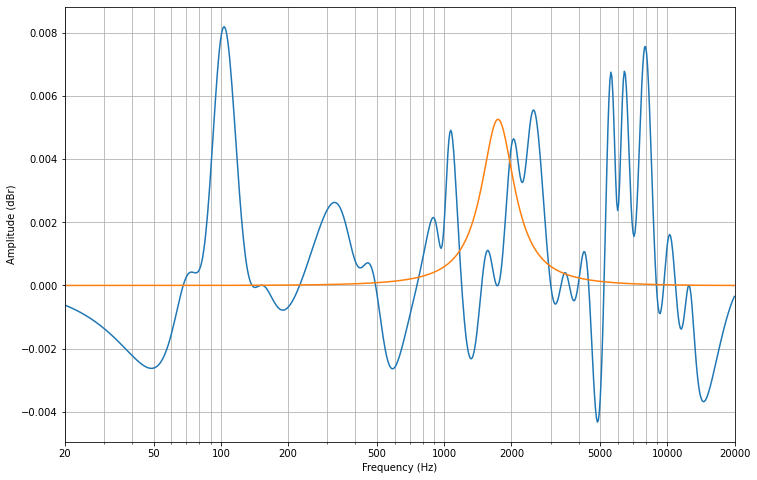

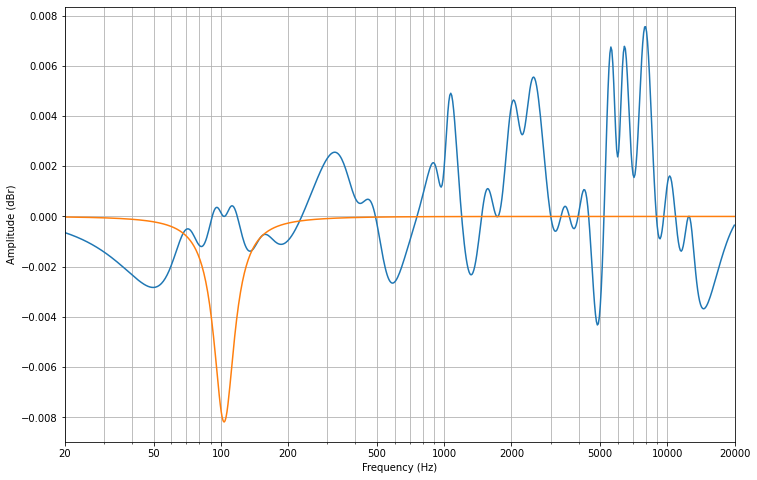

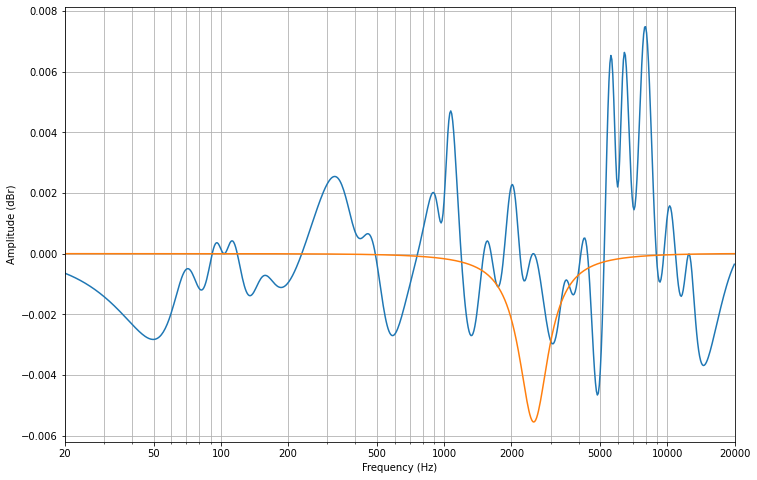

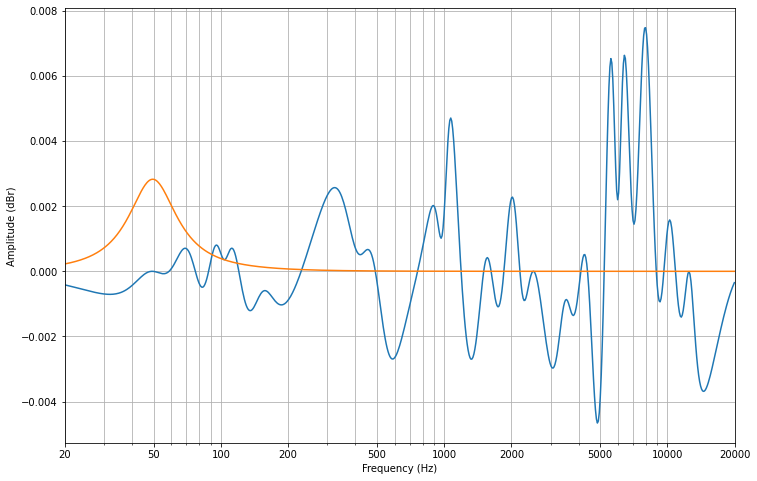

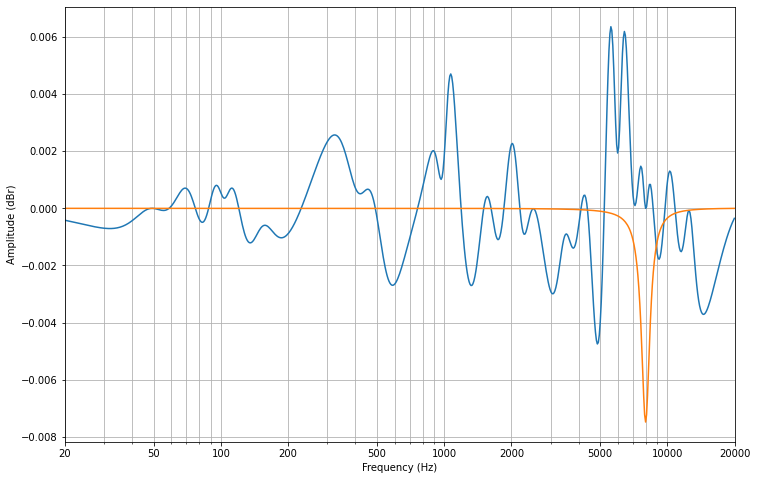

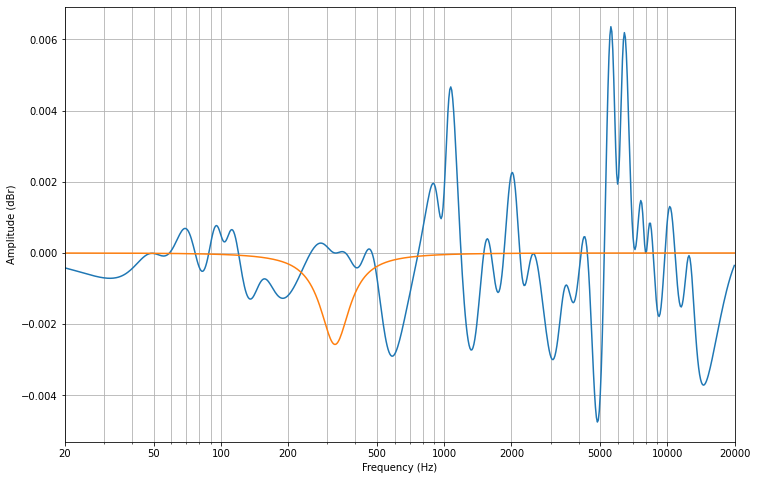

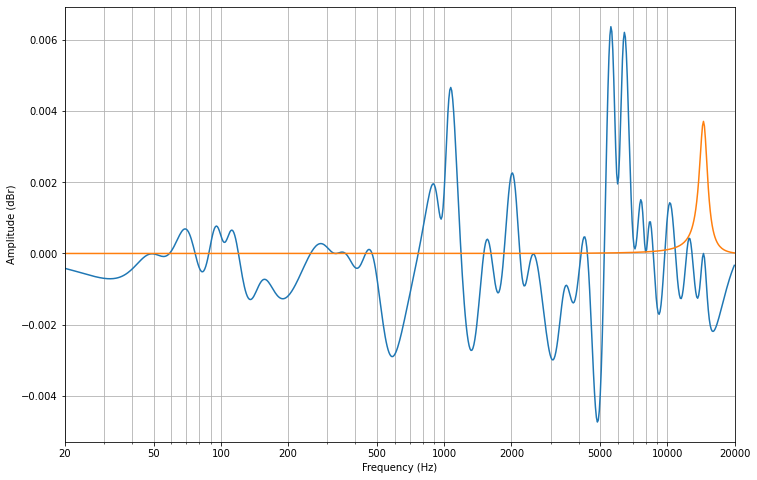

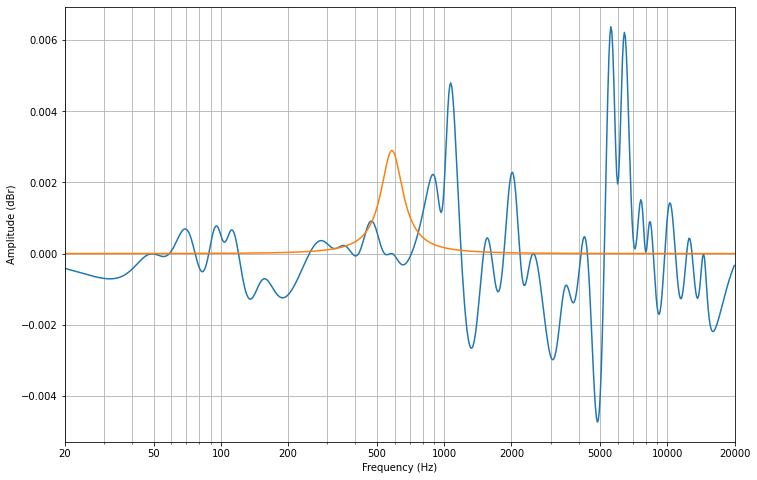

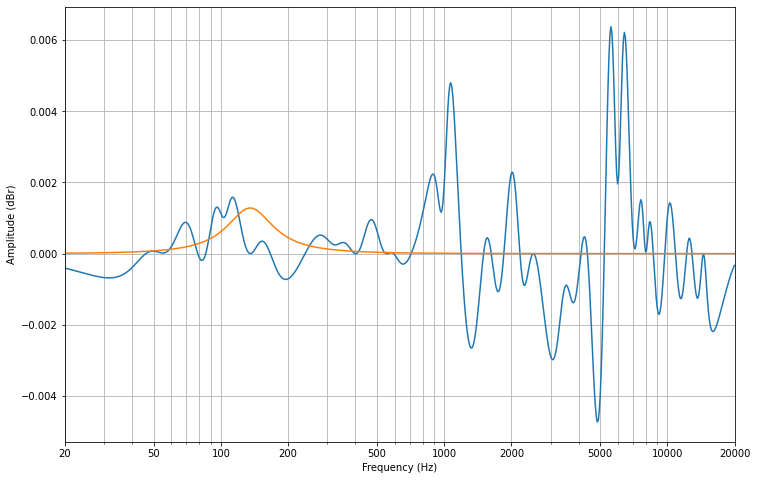

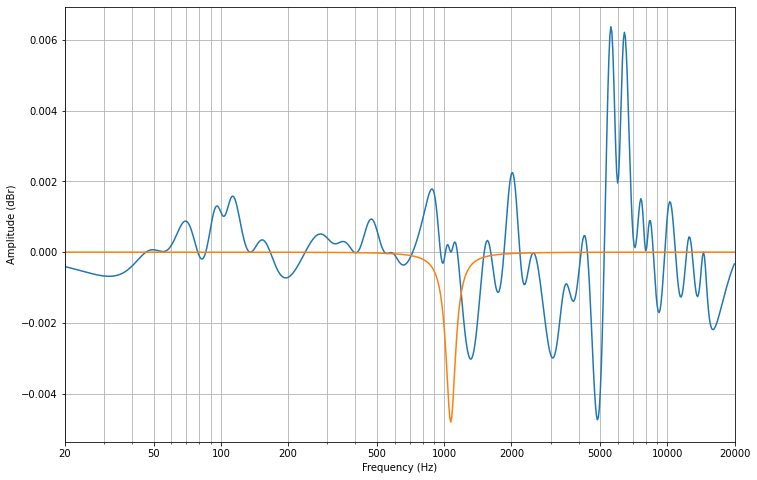

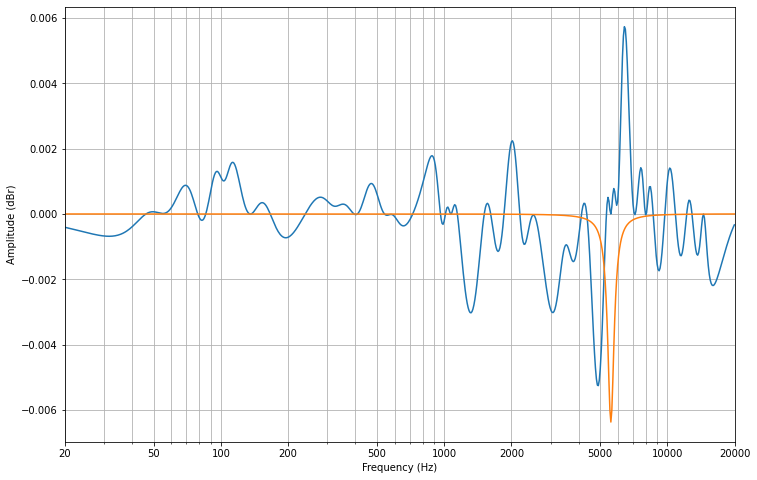

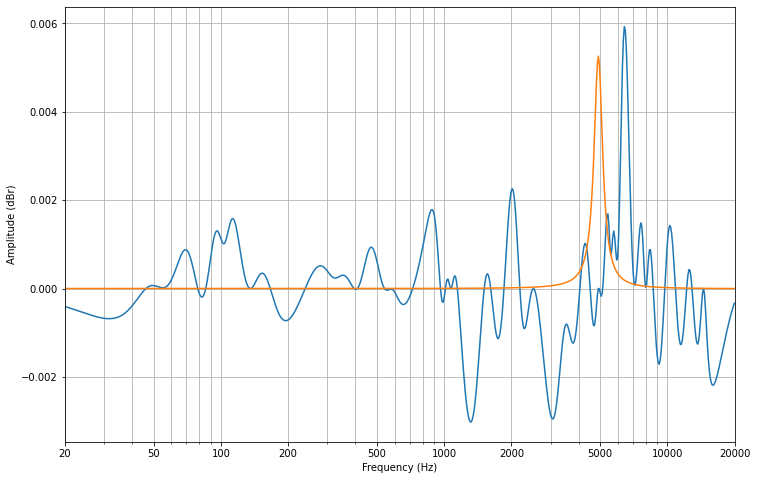

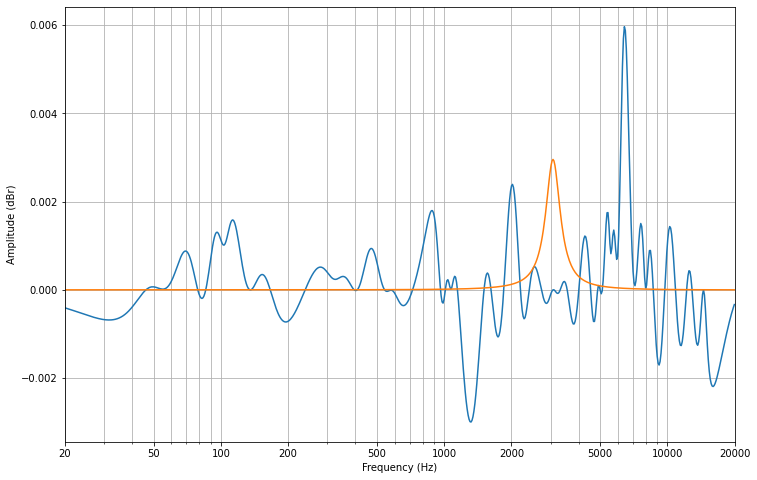

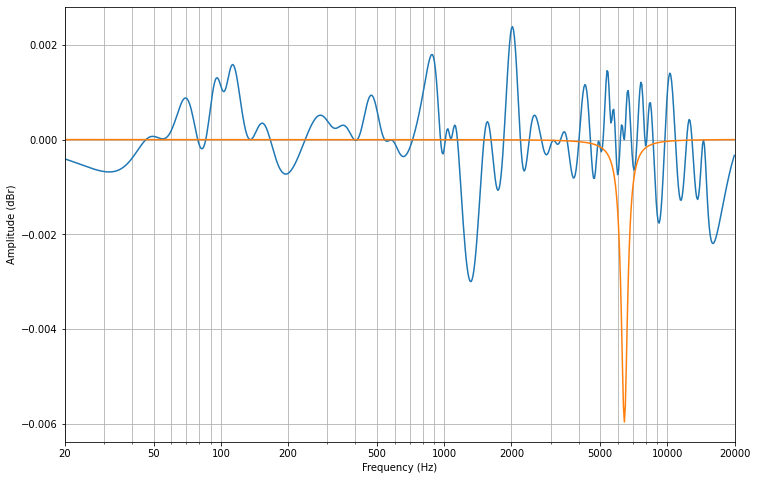

In [84]:
remainder = fr.copy()
fig, ax = FrequencyResponse.init_plot()
ax.plot(f, remainder)
for _ in range(30):
    ixs, widths, heights = biggest_peaks(remainder)
    ix = ixs[0]
    width = widths[0]
    height = heights[0]
    if remainder[ix] < 0:
        height *= -1
    bw = np.log2((2**f_step)**width)
    q = np.sqrt(2**bw) / (2**bw - 1)
    fig, ax = FrequencyResponse.init_plot()
    print(f[ix], width, bw, q, height)
    filter_fr = digital_coeffs(f, 44100, *peaking(f[ix], q, -height, fs=44100))
    remainder += filter_fr
    ax.plot(f, remainder)
    ax.plot(f, filter_fr)
plt.show()

In [58]:
(1 + f_step)**20

1.3298479694014367